# Working with (partially specified) Boolean networks

This part of AEON offers basic functionality for working with Boolean networks. In particular, it supports **three major formats** (`.bnet`, `.sbml`, and `.aeon`), can perform basic **integrity checks** (e.g. that an update function only uses variables that are actually declared as regulators, etc.), and can be used to run simple operations on the regulatory graph (like decomposition into **strongly connected components** or detection of **parity cycles**).

Additionally, AEON support "partially specified" networks. Here, the update functions can use declared unknown (uninterpreted) functions. For example, this means that if your data isn't sufficient to actually produce a single "correct" network, you can automatically work with whole ensemble (also collection) of networks with different dynamical properties.

In [1]:
from biodivine_aeon import *
import biodivine_aeon as ba
import graphviz as gv

Detected IPython (`ZMQInteractiveShell`). Log level set to `LOG_ESSENTIAL`.


If you have an existing model that you want to work with, you can load it right away as a Boolean network. Here, we will use (for demonstration) a very simple model with 5 variables:

In [2]:
g2a = BooleanNetwork.from_file('./data/g2a.sbml')
print(g2a.variable_count())

# You can also use:
# BooleanNetwork.from_sbml(...)
# BooleanNetwork.from_bnet(...)
# BooleanNetwork.from_aeon(...)
# However, these accept the model file content, not the file path.

5


Similarly, if you already have a Boolean network, you can easily output it to one of these formats using a `to_*` method. Just keep in mind that every format has slightly different capabilities (for example, `bnet` does not keep track of the underlying regulatory graph, so this information will be lost).

In [3]:
print(g2a.to_sbml()[0:500] + "...")

<?xml version='1.0' encoding='UTF-8' standalone='no'?><sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" layout:required="false" level="3" qual:required="true" xmlns:layout="http://www.sbml.org/sbml/level3/version1/layout/version1" version="1" xmlns:qual="http://www.sbml.org/sbml/level3/version1/qual/version1"><model><qual:listOfQualitativeSpecies xmlns:qual="http://www.sbml.org/sbml/level3/version1/qual/version1"><qual:qualitativeSpecies qual:maxLevel="1" qual:constant="false" qual:nam...


In [4]:
print(g2a.to_bnet())

targets,factors
CcrM, ((CtrA & !CcrM) & !SciP)
CtrA, (((CtrA & !CtrA) | ((((!CtrA & GcrA) & !CcrM) & !SciP) & (CtrA | !CtrA))) | ((CtrA & !CcrM) & !SciP))
DnaA, (((CtrA & !GcrA) & !DnaA) & CcrM)
GcrA, (!CtrA & DnaA)
SciP, (CtrA & !DnaA)



In [5]:
print(g2a.to_aeon())

CtrA -> CtrA
GcrA -> CtrA
CcrM -| CtrA
SciP -| CtrA
CtrA -| GcrA
DnaA -> GcrA
CtrA -> DnaA
GcrA -| DnaA
DnaA -| DnaA
CcrM -> DnaA
CtrA -> CcrM
CcrM -| CcrM
SciP -| CcrM
CtrA -> SciP
DnaA -| SciP
$CcrM: CtrA & !CcrM & !SciP
$CtrA: false | (!CtrA & GcrA & !CcrM & !SciP & true) | (CtrA & !CcrM & !SciP)
$DnaA: CtrA & !GcrA & !DnaA & CcrM
$GcrA: !CtrA & DnaA
$SciP: CtrA & !DnaA



## `RegulatoryGraph` (a.k.a. influence graph)

If you want to create your network in code, you usually start with a `RegulatoryGraph`. 

A regulatory graph represents variables connected using regulation edges (influences). Each regulation edge can have a **sign** (`+` represents activation, `-` represents inhibition, `None` means the sign is unknown). Each edge can be also marked as **essential** (`True` or `False`). 

The sign dictates the monotonicity of the interaction: once we assign an actual Boolean function to this regulation, it must be non-decreasing (activation) or non-increasing (inhibition) in the input coresponding to the regulator. Meanwhile, an essential regulation must have an impact on the regulated variable, while non-essential inputs may simply be ignored by the update function.

In [6]:
# To create a regulatory graph, you give it a list of variables that you want to create.
rg = RegulatoryGraph(["a", "b", "c"])
print(rg)
print(rg.variables())
print(rg.variable_names())

# You can also specify a list of regulations as the second argument. However, we haven't
# shown how regulations are described yet.
# rg = RegulatoryGraph(variables=["a", "b", "c"], regulations=[...])

RegulatoryGraph(variables=3, regulations=0)
[VariableId(0), VariableId(1), VariableId(2)]
['a', 'b', 'c']


Notice that the variables in the regulatory graph are identified using `VariableId` objects, which are essentially typed integer indices. This is mostly to avoid working with name strings outside of the Boolean network or the regulatory graph (it also allows us to rename variables easily). However, most of the Python API should happily accept both a variable name and a `VariableId` object.

You can always translate between the two easily:

In [7]:
rg.get_variable_name(VariableId(1))

'b'

In [8]:
rg.find_variable("c")

VariableId(2)

We can't add/remove variables in a `RegulatoryGraph` directly, since this could disrupt any existing `VariableId` references. However, there are two utility methods that help us create a copy of the `RegulatoryGraph` with variables added/removed:

In [9]:
print(rg.extend(["x", "y"]))
print(rg.drop(["b"]))  # The `drop` method also automatically removes any associated regulations.

RegulatoryGraph(variables=5, regulations=0)
RegulatoryGraph(variables=2, regulations=0)


Now, we can start adding regulations to our graph:

In [10]:
rg.add_regulation({ 
    "source": "a", 
    "target": "b", 
    "sign": "+", 
    "essential": True 
})

rg.add_regulation({ 
    "source": "b", 
    "target": "c", 
    "sign": None, 
    "essential": False 
})
rg.add_regulation({ 
    "source": "b", 
    "target": "a", 
    "sign": None, 
    "essential": False
})

# A self-regulation:
rg.add_regulation({ 
    "source": "a", 
    "target": "a", 
    "sign": None, 
    "essential": False
})

# You can also use `.aeon` syntax to add regulations more concisely:
rg.add_regulation("c -> c")

# Currently, these combinations are supported:
# -?? | sign: None, essential: False
# ->? | sign: +, essential: False
# -|? | sign: -, essential: False
# -? | sign: None, essential: True
# -> | sign: +, essential: True
# -| | sign: -, essential: True

rg.regulations()

[{'source': VariableId(0),
  'target': VariableId(1),
  'essential': True,
  'sign': '+'},
 {'source': VariableId(1),
  'target': VariableId(2),
  'essential': False,
  'sign': None},
 {'source': VariableId(1),
  'target': VariableId(0),
  'essential': False,
  'sign': None},
 {'source': VariableId(0),
  'target': VariableId(0),
  'essential': False,
  'sign': None},
 {'source': VariableId(2),
  'target': VariableId(2),
  'essential': True,
  'sign': '+'}]

You can of course search for existing regulations, but you can also use `ensure_regulation` to update regulations (if the regulation does not exist, it is created):

In [11]:
print(rg.find_regulation("a", "b"))
rg.ensure_regulation("a -|? b")
print(rg.find_regulation("a", "b"))

{'source': VariableId(0), 'target': VariableId(1), 'essential': True, 'sign': '+'}
{'source': VariableId(0), 'target': VariableId(1), 'essential': False, 'sign': '-'}


To inspect the `RegulatoryGraph` visually, you can export it as a `.dot` graph. You can also export it to `.aeon` and open it in the interactive AEON model editor.

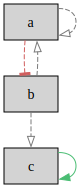

In [12]:
gv.Source(rg.to_dot())

#### Structure of the `RegulatoryGraph`

Once we have a graph, we can perform some basic exploration of its structure:

In [13]:
rg.predecessors("b") # Regulators

{VariableId(0)}

In [14]:
rg.successors("b") # Targets

{VariableId(0), VariableId(2)}

In [15]:
rg.backward_reachable("b") # Transitive regulators

{VariableId(0), VariableId(1)}

In [16]:
rg.forward_reachable("b") # Transitive targets

{VariableId(0), VariableId(1), VariableId(2)}

We can even run a simple SCC decomposition algorithm which will reveal variables that are mutually influencing each other. Here, we know that `a` and `b` have a cycle together, and `c` is only influenced by `b`, but has a self-regulation.

In [17]:
rg.strongly_connected_components()

Found SCC with 3 nodes.
Found SCC with 2 nodes.


[{VariableId(2)}, {VariableId(0), VariableId(1)}]

Several other graph algorithms are also supported. For all of these, you can provide an optional `subgraph` argument to restrict the operation to a particular induced subgraph of the original input:

In [18]:
# The shortest cycle starting in variable "c", or `None` if there is no such cycle.
# If parity is specified, only positive/negative cycles are considered.
c_cycle = rg.shortest_cycle(pivot="c")
c_positive = rg.shortest_cycle(pivot="c", parity="+")
c_negative = rg.shortest_cycle(pivot="c", parity="-")

# Note that while both variants of the problem have polynomial complexity, parity cycle detection
# has a higher complexity exponent and can be thus measurably slower for large networks.

# A close to minimal collection of vertices such that every cycle intersects at least one vertex.
fvs = rg.feedback_vertex_set()
# The same as above, but only considers negative cycles (odd number of negative edges).
nfvs = rg.feedback_vertex_set(parity='-')

# A close to maximal set of independent cycles. That is, cycles that do not intersect.
ic = rg.independent_cycles()
# The same as above, but only considers positive cycles (even number of negative edges).
pic = rg.independent_cycles(parity='+')

# Note that minimal FVS, resp. maximal IC problems are NP complete. Hence we only consider 
# a (good enough) approximation in our outputs. However, the result is always a valid FVS/IC set.
# Only the minimality/maximality is not guaranteed.

Starting FVS computation with 3 candidates.
Selected VariableId(0) as candidate with cycle length 1.
Selected VariableId(2) as candidate with cycle length 1.
Finished initial FVS pruning with 2 candidates.
Selected VariableId(0) as candidate with cycle length 1.
Selected VariableId(2) as candidate with cycle length 1.
Finished FVS computation: 2 nodes.
Starting FVS computation with 3 candidates.
Selected VariableId(0) as candidate with cycle length 1.
Selected VariableId(2) as candidate with cycle length 1.
Finished initial FVS pruning with 2 candidates.
Selected VariableId(0) as candidate with cycle length 1.
Selected VariableId(2) as candidate with cycle length 1.
Finished FVS computation: 2 nodes.
Starting parity FVS computation with 2 candidates.
Selected VariableId(0) as candidate with cycle length 1.
Finished parity FVS computation: 1 nodes.
Selected [VariableId(0)] as the shortest candidate.
Selected [VariableId(2)] as the shortest candidate.
Selected [VariableId(0)] as the shor

In [19]:
print(f"Shortest cycle on 'c': {c_cycle}")
print(f"Shortest positive cycle on 'c': {c_positive}")
print(f"Shortest negative cycle on 'c': {c_negative}")
print(f"Feedback vertex set: {fvs}")
print(f"Negative feedback vertex set: {nfvs}")
print(f"Independent cycles: {ic}")
print(f"Positive independet cycles: {pic}")

Shortest cycle on 'c': [VariableId(2)]
Shortest positive cycle on 'c': [VariableId(2)]
Shortest negative cycle on 'c': None
Feedback vertex set: {VariableId(0), VariableId(2)}
Negative feedback vertex set: {VariableId(0)}
Independent cycles: [[VariableId(0)], [VariableId(2)]]
Positive independet cycles: [[VariableId(0)], [VariableId(2)]]


### Log output

*This is probably a good place to talk about the **logging** mechanism in AEON.* 

As you can see, the methods above also printed additional progress messages on top of the requested output. Be default, this behavior is enabled when AEON detects that it is running in an interactive mode, such as a Jupyter notebook. However, you can tune it using the global `LOG_LEVEL` variable:

In [20]:
ba.LOG_LEVEL = ba.LOG_NOTHING
print(rg.strongly_connected_components())
ba.LOG_LEVEL = ba.LOG_ESSENTIAL
print(rg.strongly_connected_components())

[{VariableId(2)}, {VariableId(1), VariableId(0)}]
[{VariableId(2)}, {VariableId(1), VariableId(0)}]
Found SCC with 3 nodes.
Found SCC with 1 nodes.


Aside from `LOG_NOTHING` and `LOG_ESSENTIAL` (default in Jupyter), `LOG_VERBOSE` is also available to show additional messages in some long-running algorithms. However, for the graph algorithms discussed so far, the verbose mode does not add any new output.

Finally, a `BooleanNetwork` **inherits** from a `RegulatoryGraph`. Hence everything that we have shown so far for a `RegulatoryGraph` can be also applied to a `BooleanNetwork`.

In [21]:
g2a.strongly_connected_components()

Found SCC with 5 nodes.


[{VariableId(0), VariableId(1), VariableId(2), VariableId(3), VariableId(4)}]

In this case, we see that the g2a network has only one component, consisting of all its variables.

## `BooleanNetwork` (adding functions and parameters)

A Boolean network is essentially a regulatory graph with update functions for each variable. However, as we mentioned above, our Boolean networks can also contain update functions that are either unknown (implicit parameters), or partially defined using declared uninterpreted Boolean functions (explicit parameters).

In [22]:
# Create a Boolean network from a known regulatory graph.
bn = BooleanNetwork(rg)

# Since `BooleanNetwork` inherits from a `RegulatoryGraph`, you can
# also create a network with a list of variables, regulations, and 
# optionally parameters functions.
# bn = BooleanNetwork(["a", "b", "c"], regulations=[ ... ], parameters=[ ... ], functions={ ... })

# Initially, all update functions are undefined:
print(f"Function of 'a': {bn.get_update_function("a")}")

# Such undefined functions are also referred to as "implicit parameters".
# The following returns a collection of variable IDs with the airty
# of the corresponding unknown function.
print(bn.implicit_parameters())

Function of 'a': None
{VariableId(0): 2, VariableId(1): 1, VariableId(2): 2}


We can still work with such a network, but in this case, we would have to consider **every possible** update function for every variable (as long as it satisfies the requirements on the regulation sign and essentiality). That is mostly fine for very small networks like this one, but would be impossible to solve for networks with hundreds of variables and thousands of regulations.

To specify exact update functions, we can simply provide a Boolean expression which describes the function:

In [23]:
bn.set_update_function("a", "b & !a")
print(f"Function of 'a': {bn.get_update_function("a")}")
print(bn.implicit_parameters()) # Variable "a" is no longer an implicit parameter.

Function of 'a': b & !a
{VariableId(2): 2, VariableId(1): 1}


Note that `b -> a` is an activation, hence `b` must "positively" influence the outcome of this update function. However, whether this holds is not verified by the Boolean network directly; it is only tested once we try to create an asynchronous transition graph for the network in the next tutorial.

If we don't know the whole function, we can simply leave it as `None`. However, we can also use "basic" logical parameters (constant unknown values) and uninterpreted functions to make the function partially defined:

In [24]:
# Add a basic "explicit" parameter. Arity 0 means the parameter represents 
# a `true`/`false` constant.
bn.add_explicit_parameter("p1", arity=0)

# Update function for `c` will depend on `c` only when `p1` is set.
bn.set_update_function("c", "b & (p1 => c)")

# Parameter of arity one is a Boolean function with one argument.
bn.add_explicit_parameter("p2", arity=1)

# We can use it for example like this (and overwrite the previous
# function declared above).
bn.set_update_function("c", "b & p2(c)")

print(bn.get_update_function("c"))

b & p2(c)


Here, update function for `c` can be `b & c`, `b & !c`, `b & true`, or `b & false`, depending on `p2`. This is because the self-regulation has no sign (hence `c` can appear positively or negatively) and may not be essential (`c` may not appear at all, in which case `p2` is a constant function).

Note that this makes the function `p1` unsued, which adds additional unnecessary complexity. We can quickly prune all unused functions though:

In [25]:
print(bn)
bn = bn.prune_unused_parameters()
print(bn)

BooleanNetwork(variables=3, regulations=5, explicit_parameters=2, implicit_parameters=1)
BooleanNetwork(variables=3, regulations=5, explicit_parameters=1, implicit_parameters=1)


Explicit parameters are particular useful when we deal with variables that have multiple regulators:

In [26]:
print(g2a.get_update_function("CtrA"))

false | (!CtrA & GcrA & !CcrM & !SciP & true) | (CtrA & !CcrM & !SciP)


In [27]:
g2a.add_explicit_parameter("f1", arity=2)
g2a.set_update_function("CtrA", "CtrA & !SciP & f1(CcrM, GcrA)")

print(g2a.get_update_function("CtrA"))

CtrA & !SciP & f1(CcrM, GcrA)


Here, we clearly specify that the value of `CtrA` has a known dependence on `CtrA` and `SciP`, but unknown on `CcrM` and `GcrA`.

### `UpdateFunction` class

For now, we have manipulated update functions purely as strings. However, there is a dedicated `UpdateFunction` class that can be useful when manipulating functions in Python. In fact, `get_update_function` returns a result of this type.

In [28]:
# An UpdateFunction can be created from a string with a BooleanNetwork as "context".
fun_1 = UpdateFunction(bn, "b & p2(c)")

# But, you can also create an UpdateFunctions using one of the `mk_*` type constructors:
fun_a = UpdateFunction.mk_var(bn, "a")
fun_2 = UpdateFunction.mk_and(fun_1, fun_a)
print(fun_2)

# For each UpdateFunction variant, there is also a `is_*` test method, and a `as_*`
# destructor method (see also `BooleanExpression` in the previous tutorial).
assert fun_2.is_and()
(x,y) = fun_2.as_and()
assert x == fun_1
assert y == fun_a

b & p2(c) & a


There are several utility methods on the `UpdateFunction` class that can be used to perform some basic analysis and transformations:

In [29]:
print(f"Variables that appear in 'fun_1': {fun_1.support_variables()}")
print(f"Parameters that appear in 'fun_1': {fun_1.support_parameters()}")

# Substitute all occurences of a variable with the given function.
print(fun_1.substitute_all({ "c": fun_1 }))

# Push all negations down to atomic expressions (variables or functions).
print(UpdateFunction(bn, "!(a | b)").distribute_negation())

# Transform all logical operators (=>, ^, <=>) into conjuctions and disjunctions.
print(UpdateFunction(bn, "a => b").to_and_or_normal_form())

# Propagate all true/false constants:
print(UpdateFunction(bn, "a & b & false").simplify_constants())

# Convert the `UpdateFunction` into a `BooleanExpression`.
# This operation only works if the function does not use any uninterpreted 
# functions of non-zero arity.
print(UpdateFunction(bn, "a & b").as_expression())

Variables that appear in 'fun_1': {VariableId(1), VariableId(2)}
Parameters that appear in 'fun_1': {ParameterId(0)}
b & p2(b & p2(c))
!a & !b
!a | b
false
(a & b)


### `BooleanNetwork` transformations

Finally, there are a few useful utlity methods available for the `BooleanNetwork` itself.

First, you can remove all regulation constraints. This is useful for example when they are for some reason not satisfiable and you want to disregard them completely. 

This usually should not be necessary: instead, you should replace the constraints in the network to the valid ones. However, sometimes you might just want to ignore everything and start over.

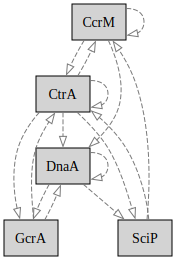

In [30]:
g2a_clear = g2a.remove_regulation_constraints()
gv.Source(g2a_clear.to_dot())

You can then also infer the constraints back from the network's update functions.

Just keep in mind that this can only work with update functions that are at least partially known. That is, we cannot infer any sign or essentiality for a fully unknown function. This is why the `CtrA` regulations below remain largely unspecified. The update functions of the remaining variables are fully known, but the function of `CtrA` is only partially known, hence we cannot infer all regulation properties exactly.

CtrA & !SciP & f1(CcrM, GcrA)


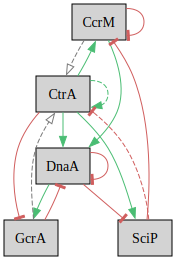

In [31]:
g2a_inferred = g2a_clear.infer_valid_graph()
print(g2a_inferred.get_update_function("CtrA"))
gv.Source(g2a_inferred.to_dot())

Finally, we can inline various objects in a `BooleanNetwork`:

 - We can **inline a single variable**, as long as it does not have a self-regulation. This simply replaces every occurence of the inlined variable with its update function.
 - We can **inline all constant variables**. A variable is a constant if its update function is either `true` or `false`. This can be evaluated either syntactically (simply check if the function is a constant), or semantically (catches all tautologies and contradictions, for example `a | !a` or `a & !a`). The default is the syntactic check, but semantic check can be enabled with the `infer_constants=True` argument.

   All constants are propagated until a fixed-point is reached. If the propagation causes another variable to become a constant, this variable is also inlined.

 - We can **inline input variables**. A variable is an input if (a) its update function is unknown and it has no declared regulators, or (b) its update function is equivalent to an identity function (e.g. `f_a = a`). Similar to constants, condition (b) can be checked either syntactically (`infer_inputs=False`; faster, but less robust), or semantically (`infer_inputs=True`). Each detected input is converted into a zero-arity explicit parameter.

Applying these methods to complex networks can often result in unsatisfiable regulation constraints. This is not a bug, but a property of the process. For example, consider a function `f=a & b`. In this function, both `a` and `b` are essential. However, inlining `a=false` into this function results in `f = false & b = false`. Hence `b` is no longer essential in `f` and the previously valid regulation constraint is now broken. 

To resolve this problem, each method has an optional `repair_graph` argument which ensures that regulation constraints are fixed according to the newly generated update functions.

GcrA = '!CtrA & DnaA', CtrA='CtrA & !SciP & f1(CcrM, GcrA)'
CtrA & !SciP & f1(CcrM, false)


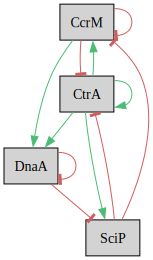

In [32]:
print(f"GcrA = '{g2a.get_update_function("GcrA")}', CtrA='{g2a.get_update_function("CtrA")}'")
g2a_reduced = g2a.inline_variable("GcrA", repair_graph=True)
print(g2a_reduced.get_update_function("CtrA"))
gv.Source(g2a_reduced.to_dot())

Note that here, the `repair_graph` procedure actually uncovered an interesting property of the `CtrA` update function. After syntactic inlining, the update function is `CtrA & !SciP & f1(CcrM, !CtrA & DnaA)`. However, this function actually does not depend on the value of `DnaA` at all!

 - `CtrA & !SciP & f1(CcrM, !CtrA & false)` simplifies to `CtrA & !SciP & f1(CcrM, false)`.
 - `CtrA & !SciP & f1(CcrM, !CtrA & true)` simplifies to `CtrA & !SciP & f1(CcrM, !CtrA)`. But this is semantically equivalent to `CtrA & !SciP & f1(CcrM, false)`. Why? Well, we can split the proof based on the value of `CtrA`. If `CtrA=false`, both variants simplify to `false`. And if `CtrA=true`, both variants simplify to `!SciP & f1(CcrM, false)`.

Hence, we can simplify the update function to `CtrA & !SciP & f1(CcrM, false)` and remove the `DnaA -> CtrA` regulation.

If we use `repair_graph=False`, this transformation does not happen, because AEON will not simplify the resulting network in any way (feel free to change the code above to test this).

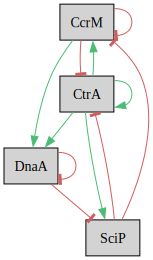

In [33]:
gv.Source(g2a_reduced.infer_valid_graph().to_dot())

In [34]:
bn = BooleanNetwork(["a", "b", "c"], ["a -? a", "a -> b", "b -| c", "c -> c"], functions={"a": "a | !a"})
print(bn.inline_constants(infer_constants=True, repair_graph=True).to_aeon())

b -| c
c -> c
$b: f_b(true)



In [35]:
bn = BooleanNetwork(["a", "b", "c"], ["a -? a", "a -> b", "b -| c", "c -> c"], functions={"a": "a"})
print(bn.inline_inputs(infer_inputs=True, repair_graph=True).to_aeon())

b -| c
c -> c
$b: f_b(a)



This summarises the core API of the `RegulatoryNetwork` and the `BooleanNetwork`. For more information about these classes, you can follow the API documentation [here](https://biodivine.fi.muni.cz/docs/aeon-py/latest/).